In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#1. Data Preparation

In [39]:
df = pd.read_csv("/content/churn.csv")

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


In [41]:
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [42]:
df.duplicated().sum()

np.int64(14)

In [43]:
df.drop_duplicates(inplace=True)

In [44]:
df.isnull().sum()

,0
customerID,9
Gender,15
SeniorCitizen,12
Partner,16
Dependents,19
Tenure,17
Contract,13
PaperlessBilling,13
PaymentMethod,11
MonthlyCharges,10


In [45]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)
#filling nulls with modes (categorical) and medians (numerical)

In [46]:
df.isnull().sum()

,0
customerID,0
Gender,0
SeniorCitizen,0
Partner,0
Dependents,0
Tenure,0
Contract,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0


In [47]:
#customerID is not useful for prediction
df = df.drop(columns=['customerID'])

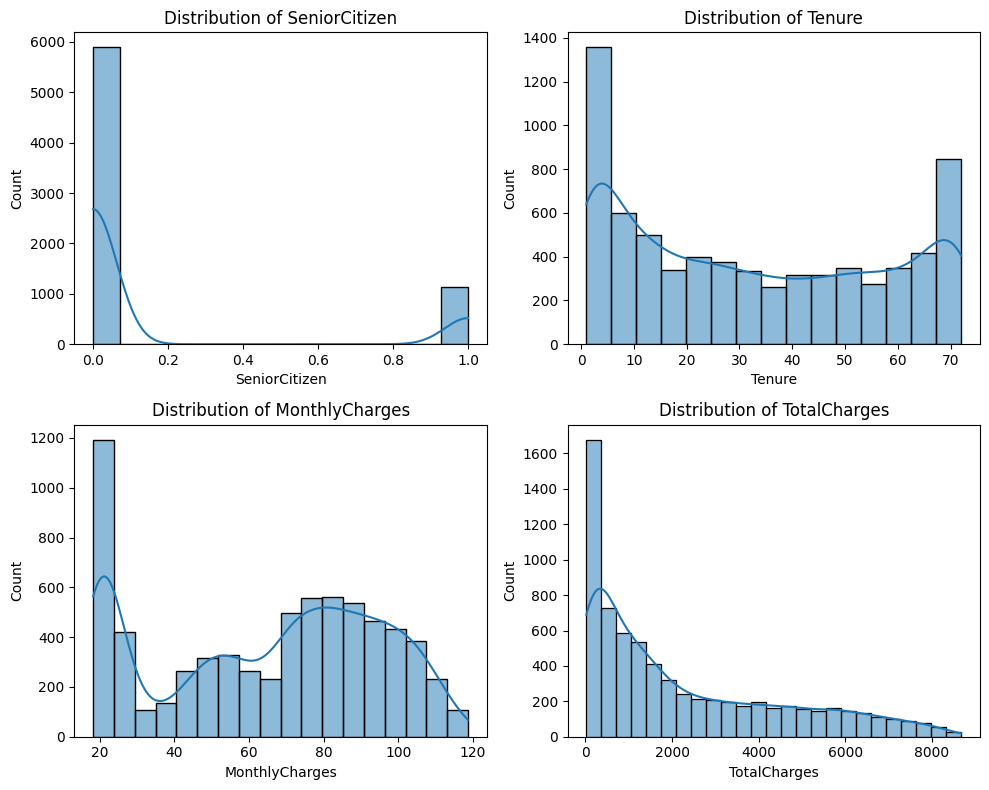

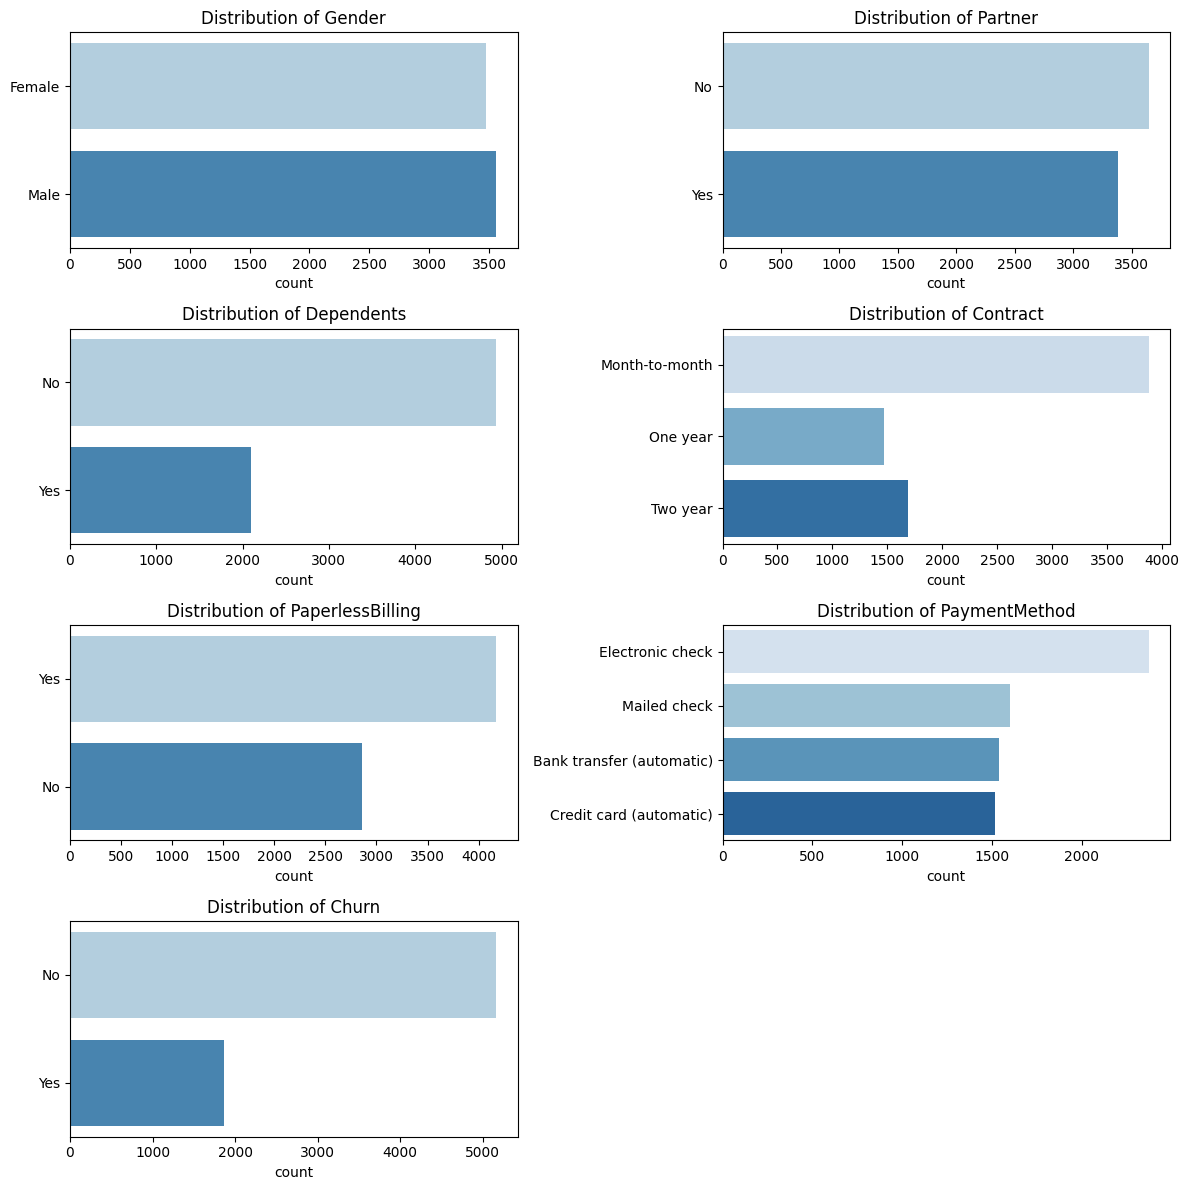

In [48]:
#Data Distribution

#NUMERICAL FEATURES
num_cols = df.select_dtypes(include='number').columns

n_cols = 2
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# CATEGORICAL FEATURES TARGET
cat_cols = df.select_dtypes(include='object').columns

n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(
        y=df[col],
        ax=axes[i],
        palette='Blues'
    )
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel(None)

# Hapus subplot kosong
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Conclusion**:

Duplicated datas have been removed

Missing values are handled by imputing the mode for categorical features and the median for numerical features.

Outlier handling is not required, as the observed distributions does not reflect data errors.

#2. Splitting Data

In [49]:
#Train: 70%
#Validation: 15%
#Test: 15%

from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)


In [50]:
X_cat = X.select_dtypes(include='object')
X_cat_cols = X.select_dtypes(include='object').columns
X_num = X.select_dtypes(exclude='object')
X_num_cols = X.select_dtypes(exclude='object').columns

#3. Correlation Analysis & Feature Selection

In [51]:
corr = X_num.corr()
corr_pairs = (
    corr
    .where(~np.tril(np.ones(corr.shape)).astype(bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
corr_pairs.sort_values(by='Correlation', ascending=False)


,Feature_1,Feature_2,Correlation
4,Tenure,TotalCharges,0.825494
5,MonthlyCharges,TotalCharges,0.650379
3,Tenure,MonthlyCharges,0.247547
1,SeniorCitizen,MonthlyCharges,0.220326
2,SeniorCitizen,TotalCharges,0.102167
0,SeniorCitizen,Tenure,0.014120


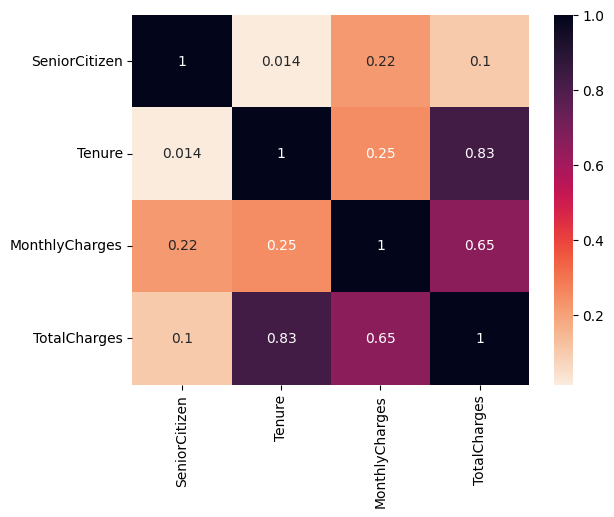

In [52]:
sns.heatmap(corr, annot=True, cmap='rocket_r')
plt.show()

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df['feature'] = X_num_cols
vif_df['VIF'] = [
    variance_inflation_factor(X_num.values, i)
    for i in range(X_num.shape[1])
]

vif_df


,feature,VIF
0,SeniorCitizen,1.257252
1,Tenure,6.324358
2,MonthlyCharges,3.699093
3,TotalCharges,8.046960


In [54]:
X = X.drop(columns=['TotalCharges']) #dropped due to high multicollinearity

In [55]:
X_cat = X.select_dtypes(include='object')
X_cat_cols = X.select_dtypes(include='object').columns
X_num = X.select_dtypes(exclude='object')
X_num_cols = X.select_dtypes(exclude='object').columns

In [56]:
corr = X_num.corr()
corr_pairs = (
    corr
    .where(~np.tril(np.ones(corr.shape)).astype(bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
corr_pairs.sort_values(by='Correlation', ascending=False)

,Feature_1,Feature_2,Correlation
2,Tenure,MonthlyCharges,0.247547
1,SeniorCitizen,MonthlyCharges,0.220326
0,SeniorCitizen,Tenure,0.014120


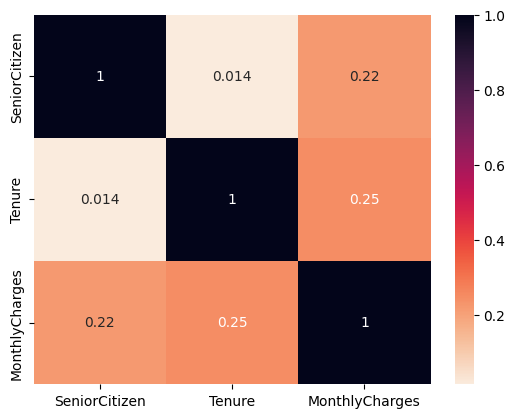

In [57]:
sns.heatmap(corr, annot=True, cmap='rocket_r')
plt.show()

In [58]:
vif_df = pd.DataFrame()
vif_df['feature'] = X_num_cols
vif_df['VIF'] = [
    variance_inflation_factor(X_num.values, i)
    for i in range(X_num.shape[1])
]

vif_df

,feature,VIF
0,SeniorCitizen,1.256459
1,Tenure,2.625400
2,MonthlyCharges,2.936127


The correlation analysis revealed a very strong linear relationship between Tenure and TotalCharges (correlation = 0.83). This finding is supported by the VIF analysis, where both variables exhibit VIF values greater than 5, indicating high multicollinearity. Since TotalCharges is largely derived from tenure and monthly charges, it was removed to reduce redundancy and improve model stability.

#4. Feature Encoding

In [59]:
# Encode target variable
y_train = y_train.map({'No': 0, 'Yes': 1})
y_val   = y_val.map({'No': 0, 'Yes': 1})
y_test  = y_test.map({'No': 0, 'Yes': 1})

In [60]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X_num_cols),
        ('cat', OneHotEncoder(drop='first'), X_cat_cols)
    ]
)


#5. Evaluation Metric Selection

In this churn prediction task, accuracy is not suitable due to class imbalance, as it may fail to identify churn customers. Therefore, recall was selected as the primary metric because it measures the model's ability to correctly detect customers who churn, which is critical to reduce missed churn cases.

F1-score was used to balance recall and precision, ensuring that the model does not generate excessive false positives while still maintaining strong churn detection performance. ROC-AUC was included as a supporting metric to evaluate the model's overall ability to distinguish between churn and non-churn customers across different classification thresholds.

In [61]:
scoring_metrics = {
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

#6. Model Training & Hyperparameter Tuning

This code compares the performance of four different models to select the best performing model for this project.

In [62]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Cross-validation strategy
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


#Models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=4,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=1.5,
        random_state=42,
        eval_metric='logloss'
    )
}

#Run cross-validation
results = []

for model_name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    cv_result = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=skf,
        scoring=scoring_metrics,
        n_jobs=-1
    )

    results.append({
        'Model': model_name,
        'Recall (CV)': cv_result['test_recall'].mean(),
        'F1-score (CV)': cv_result['test_f1'].mean(),
        'ROC-AUC (CV)': cv_result['test_roc_auc'].mean()
    })


cv_summary = pd.DataFrame(results).sort_values(
    by='F1-score (CV)', ascending=False
).reset_index(drop=True)

cv_summary


,Model,Recall (CV),F1-score (CV),ROC-AUC (CV)
0,Logistic Regression,0.801249,0.621876,0.835335
1,XGBoost,0.637647,0.617094,0.838382
2,Decision Tree,0.819578,0.611138,0.816428
3,Random Forest,0.344029,0.465177,0.836619


From the results, it is clear that Logistic Regression is the best performing model, as it achieves the highest overall performance across the three evaluation metrics. Thus, the chosen model is Logistic Regression and its hyperparameter C will be tuned.

In [63]:
from sklearn.model_selection import GridSearchCV
#New pipeline for only LR
pipe_lr = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

#Hyperparameter grid
param_grid = {
    'model__C': [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000], #default is 1
    'model__penalty': ['l2'],
    'model__solver': ['liblinear']
}



#GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring_metrics,
    refit='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

#Results
cv_results = pd.DataFrame(grid_search.cv_results_)

summary = cv_results[
    [
        'param_model__C',
        'mean_test_recall',
        'mean_test_f1',
        'mean_test_roc_auc'
    ]
]

summary.sort_values(by='param_model__C', ascending=False)



,param_model__C,mean_test_recall,mean_test_f1,mean_test_roc_auc
7,10000.0000,0.804308,0.622048,0.835320
6,1000.0000,0.804308,0.622048,0.835327
5,100.0000,0.803542,0.621648,0.835320
4,10.0000,0.803542,0.621648,0.835296
3,0.1000,0.790547,0.618804,0.835115
2,0.0100,0.777547,0.609299,0.828923
1,0.0010,0.787476,0.580433,0.812098
0,0.0001,0.792074,0.571067,0.804552


The tuning results show that Logistic Regression performance improves as the value of C increases across all three evaluation metrics. However, the performance gains become increasingly marginal, as at C = 10,000 all three metrics remain unchanged even at the fifth decimal place compared to C = 1,000.

#7. Model Evaluation

In [64]:
baseline_lr = cv_summary.loc[
    cv_summary['Model'] == 'Logistic Regression'
]

best_idx = grid_search.best_index_

tuned_lr = pd.DataFrame([{
    'Model': 'Logistic Regression (Tuned)',
    'Recall (CV)': grid_search.cv_results_['mean_test_recall'][best_idx],
    'F1-score (CV)': grid_search.cv_results_['mean_test_f1'][best_idx],
    'ROC-AUC (CV)': grid_search.cv_results_['mean_test_roc_auc'][best_idx]
}])


In [65]:
final_comparison = pd.concat(
    [baseline_lr, tuned_lr],
    ignore_index=True
)

final_comparison


,Model,Recall (CV),F1-score (CV),ROC-AUC (CV)
0,Logistic Regression,0.801249,0.621876,0.835335
1,Logistic Regression (Tuned),0.804308,0.622048,0.835327


The evaluation shows that Logistic Regression performance improves slightly after hyperparameter tuning across recall, F1-score, and ROC-AUC. However, the improvements are marginal, indicating that the baseline model already performs near optimally. Hyperparameter tuning therefore confirms model stability rather than providing significant performance gains.